In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer
from lowEBMs.Packages.RK4 import rk4alg
from lowEBMs.Packages.ModelEquation import model_equation
from lowEBMs.Packages.Variables import Vars,reset, trackerreset, datareset
from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs import update_plotstyle, moving_average
import lowEBMs.Packages.Constants as const

import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [2]:
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')
Lat_ERA,ZMT_ERA=np.loadtxt('Data/ERA_ZMT_Mean.txt')


In [3]:
def coremodule(config,P0,P_pert_ratio,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))
    elif targetmode=='Coupled':
        dataout_ZMT=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
        dataout_GMT=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))     
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            P_pert=(Pmax-Pmin)*P_pert_ratio
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert_ratio

        if targetmode=='Coupled':
            data_ZMT,data_GMT=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout_ZMT[i]=data_ZMT
            dataout_GMT[i]=data_GMT
        else:
            data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout[i]=data
            
        if targetmode=='Coupled':
            target_ZMT=target['ZMT']
            target_GMT=target['GMT']
            F_ZMT=target_comparison(data_ZMT,'ZMT',target_ZMT,targetfunction,num_paras,grid)
            F_GMT=target_comparison(data_GMT,'GMT',target_GMT,targetfunction,num_paras,grid)
            F[i]=ratio_ZMT_GMT*F_ZMT+(1-ratio_ZMT_GMT)*F_GMT
        else:
            F[i]=target_comparison(data,targetmode,target,targetfunction,num_paras,grid)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
            
        if targetmode=='Coupled':
            dataout=[dataout_ZMT,dataout_GMT]
            
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,num_paras,grid):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation):
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}
    
    if targetmode=='Coupled':
        control=True
        
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=True,parallel_config=setup)
        controlconfig=add_parameters(controlconfig,P_config,labels)
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['rk4input'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    Vars.T,Vars.T_global=ZMT,GMT   
    data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)
    
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        dataZMT=data[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        data_out=dataZMT
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
    elif targetmode=='Coupled':
        dataZMT=data_CTRL[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        dataGMT=np.transpose(data[2][:-1]-data[2][0])
        data_out=[dataZMT,dataGMT]
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [6]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
labels=[['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['func1','a'],['func1','b']]
P0=np.array([0.5,1.9e-15,1.165,1.165,1.165])
Pmin=np.array([0.4,0.5e-15,0.9,0.9,0.9])
Pmax=np.array([0.6,5e-15,1.3,1.3,1.3])

"""labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P0=np.array([70*4.2e6,230,2.5,1.165,1.165,1.165])
Pmin=np.array([1*4.2e6,190,1.9,0.9,0.9,0.9])
Pmax=np.array([150*4.2e6,250,3.3,1.3,1.3,1.3])"""

#labels=[['func3','f1'],['func3','f2'],['func3','f3'],['func3','f4'],['func3','f5'],['func3','f6'],['func3','f7'],['func3','f8'],['func3','f9'],['func3','f10'],\
#       ['func3','f11'],['func3','f12'],['func3','f13'],['func3','f14'],['func3','f15'],['func3','f16'],['func3','f17'],['func3','f18']]
#P0=np.zeros(18)
#Pmax=np.full(18,50)
#Pmin=np.full(18,-50)
P_pert_ratio=1/10000
precision=1e-5
maxlength=int(100)
targetmode='ZMT'
target=ZMT_10
targetfunction='LeastSquare'
num_params=5
gamma0=1e-7
ratio_ZMT_GMT=0.5
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': num_params*2+1}

config_base=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini')
variable_importer(config_base,parallel=True,parallel_config=setup)
#print(config_base)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat
control=False
controlconfig=0
#print(Vars.T)
#config,P0,P_pert,labels,maxlength,target,function,precision,num_paras,gamma0):
#builtins.number_of_integration=100
F, dF, P, Ptrans, gamma, data=coremodule(config_base,P0,P_pert_ratio,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,\
            maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,controlconfig)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0


[2292.14935724 2285.91335173 2298.39082043 2271.19734478 2313.20305479
 2292.08942435 2292.20929162 2292.13723958 2292.16147497 2291.93006489
 2292.36867039]
1e-07
[5.02495494e-01 2.20379130e-15 1.16503619e+00 1.16500732e+00
 1.16513241e+00]
Iteration no.1


[452.05972959 453.11788046 451.00296681 453.87033038 450.25138698
 452.06470904 452.05475019 452.06119766 452.05826153 452.08294228
 452.03651848]
9.18180196949249e-08
[5.02107119e-01 2.17976003e-15 1.16503343e+00 1.16500650e+00
 1.16511954e+00]
Iteration no.2


[340.90859848 341.82110426 339.99747163 342.54122248 339.27878169
 340.91277461 340.90442244 340.9098236  340.90737337 340.92780111
 340.88939773]
8.775277216458507e-07
[4.98906543e-01 1.97271229e-15 1.16501130e+00 1.16500001e+00
 1.16501781e+00]
Iteration no.3


[468.68565296 467.34638074 470.02666713 464.91715989 472.47227128
 468.67291307 468.69839325 468.68258189 468.68872406 468.63634812
 468.73496385]
2.70352459555049e-07
[5.00355787e-01 2.12043192e-15 1.16503210e+00 1.16500502e+00
 1.16509829e+00]
Iteration no.4


[101.16754087 101.71735904 100.6196332  102.27867276 100.06318162
 101.17044446 101.16463747 101.16826373 101.16681802 101.17794722
 101.15713785]
2.081064434603158e-07
[4.99898899e-01 2.08708754e-15 1.16502845e+00 1.16500412e+00
 1.16508522e+00]
Iteration no.5


[31.95470008 32.2000521  31.71217584 32.48054893 31.44204976 31.95538205
 31.95401839 31.95484486 31.95455532 31.95666331 31.95274303]
3.9010645148089203e-07
[4.99518252e-01 2.05778831e-15 1.16502684e+00 1.16500378e+00
 1.16508060e+00]
Iteration no.6


[31.65531852 31.43488522 31.87845793 31.11641581 32.21002665 31.65193252
 31.65870488 31.65433169 31.65630538 31.63896143 31.67168293]
1.9098721304104504e-07
[4.99687685e-01 2.07289377e-15 1.16503075e+00 1.16500491e+00
 1.16509947e+00]
Iteration no.7


[22.0115292  22.02974311 21.99609217 22.03528162 22.0022666  22.01025674
 22.01280198 22.01113029 22.01192813 22.00465248 22.01841269]
1.8488807001876172e-07
[4.99675242e-01 2.07245232e-15 1.16503217e+00 1.16500536e+00
 1.16510715e+00]
Iteration no.8


[21.99481609 22.00509884 21.98730795 22.00045691 22.00370647 21.99347465
 21.99615785 21.99439799 21.99523421 21.9876288  22.00201017]
1.834928526935838e-07
[4.99668713e-01 2.07249544e-15 1.16503365e+00 1.16500582e+00
 1.16511511e+00]
Iteration no.9


[21.99028432 22.00029147 21.98305143 21.99529686 21.99980082 21.98894079
 21.99162816 21.98986564 21.99070302 21.98308777 21.99748766]
3.7272034566432295e-08
[4.99667428e-01 2.07250758e-15 1.16503396e+00 1.16500592e+00
 1.16511673e+00]
Iteration no.10


[21.98936708 21.99937165 21.98213673 21.99437407 21.9988884  21.9880236
 21.99071089 21.98894842 21.98978577 21.98217075 21.9965702 ]
3.49964132427524e-06
[4.99546796e-01 2.07365015e-15 1.16506235e+00 1.16501476e+00
 1.16526886e+00]
Iteration no.11


[21.9033962  21.91318809 21.89637328 21.90795205 21.9132992  21.90205696
 21.90473577 21.9029788  21.90381363 21.89622185 21.91057733]
3.7240256510731665e-06
[4.99421558e-01 2.07509029e-15 1.16509246e+00 1.16502415e+00
 1.16543025e+00]
Iteration no.12


[21.81434135 21.82745372 21.80399326 21.82649904 21.81654901 21.81303758
 21.81564543 21.81393391 21.81474882 21.80732987 21.82135959]
5.873842164586046e-07
[4.99393998e-01 2.07466760e-15 1.16509709e+00 1.16502559e+00
 1.16545513e+00]
Iteration no.13


[21.80584678 21.80930071 21.80515387 21.79599117 21.83011078 21.80445961
 21.80723427 21.80541614 21.80627744 21.79846011 21.81324023]
1.7213050819402649e-07
[4.99392570e-01 2.07509235e-15 1.16509853e+00 1.16502604e+00
 1.16546281e+00]
Iteration no.14


[21.79416991 21.80339504 21.78770698 21.79747922 21.80523286 21.79283349
 21.79550665 21.7937534  21.79458645 21.78701197 21.80133462]
2.0344180778751267e-07
[4.99386187e-01 2.07520643e-15 1.16510017e+00 1.16502655e+00
 1.16547161e+00]
Iteration no.15


[21.78915009 21.79911422 21.78194804 21.79414526 21.79851893 21.78782048
 21.79048001 21.78873548 21.78956472 21.78202298 21.79628395]
2.8902261973133984e-07
[4.99376264e-01 2.07529785e-15 1.16510249e+00 1.16502728e+00
 1.16548405e+00]
Iteration no.16


[21.78214756 21.79205446 21.77500231 21.78701521 21.79163851 21.78081795
 21.78347749 21.78173296 21.78256219 21.77502069 21.78928119]
1.427042866047663e-06
[4.99327596e-01 2.07577500e-15 1.16511395e+00 1.16503085e+00
 1.16554549e+00]
Iteration no.17


[21.74761364 21.7576408  21.74034607 21.75276916 21.75678769 21.74628755
 21.74894005 21.74720005 21.74802726 21.74050377 21.75473027]
4.793383788772213e-06
[4.99161795e-01 2.07716808e-15 1.16515233e+00 1.16504282e+00
 1.16575135e+00]
Iteration no.18


[21.63343619 21.64059862 21.62902562 21.63212783 21.64899554 21.63209333
 21.63477936 21.63301804 21.63385436 21.6262547  21.64062443]
3.7190799475437985e-07
[4.99153187e-01 2.07762177e-15 1.16515535e+00 1.16504376e+00
 1.16576748e+00]
Iteration no.19


[21.62430315 21.63663286 21.61472604 21.63473754 21.62808325 21.62300608
 21.62560055 21.62389775 21.62470858 21.61732819 21.63128485]
2.2003494985114383e-07
[4.99143547e-01 2.07751588e-15 1.16515707e+00 1.16504430e+00
 1.16577676e+00]
Iteration no.20


[21.6179568  21.62751346 21.61115173 21.62209623 21.62804321 21.61663588
 21.61927804 21.61754477 21.61836885 21.6108746  21.62504574]
1.6781399242654755e-07
[4.99138055e-01 2.07758806e-15 1.16515841e+00 1.16504471e+00
 1.16578393e+00]
Iteration no.21


[21.61392792 21.62375166 21.60685558 21.61867569 21.62340119 21.61260962
 21.61524653 21.61351662 21.61433924 21.60685766 21.62100491]
4.1434640204924705e-07
[4.99124053e-01 2.07772966e-15 1.16516171e+00 1.16504574e+00
 1.16580163e+00]
Iteration no.22


[21.60402705 21.61394024 21.59686469 21.60898205 21.61328447 21.60271024
 21.60534417 21.60361618 21.60443795 21.59696385 21.61109699]
1.8847594008495466e-06
[4.99059687e-01 2.07831612e-15 1.16517669e+00 1.16505042e+00
 1.16588205e+00]
Iteration no.23


[21.55908852 21.56851072 21.55241429 21.56294799 21.56940737 21.55777066
 21.5604067  21.5586774  21.55949967 21.55202207 21.5661617 ]
1.0612745698713795e-06
[4.99025521e-01 2.07881189e-15 1.16518514e+00 1.16505305e+00
 1.16592735e+00]
Iteration no.24


[21.53446023 21.54618215 21.52548531 21.54354522 21.53951989 21.53316427
 21.53575652 21.53405523 21.53486526 21.5274933  21.54143389]
3.566910535165172e-07
[4.99010757e-01 2.07870806e-15 1.16518793e+00 1.16505392e+00
 1.16594236e+00]
Iteration no.25


[21.52577424 21.5340714  21.52022273 21.52709648 21.53860904 21.52444898
 21.52709982 21.52536109 21.52618742 21.51867559 21.53287963]
1.6017227074055626e-07
[4.99006320e-01 2.07884142e-15 1.16518921e+00 1.16505432e+00
 1.16594923e+00]
Iteration no.26


[21.52155678 21.53111019 21.51474909 21.52573007 21.53153032 21.52024276
 21.52287112 21.52114676 21.52196682 21.51450892 21.52861136]
2.4030365596138157e-07
[4.98998457e-01 2.07894222e-15 1.16519112e+00 1.16505492e+00
 1.16595946e+00]
Iteration no.27


[21.51584258 21.52573974 21.50869089 21.52079768 21.52502771 21.51453198
 21.51715351 21.51543352 21.51625167 21.50881029 21.5228816 ]
4.4019364968206643e-07
[4.98983447e-01 2.07907688e-15 1.16519460e+00 1.16505601e+00
 1.16597816e+00]
Iteration no.28


[21.50540589 21.51515719 21.49839937 21.5100347  21.51490957 21.50409476
 21.50671734 21.50499669 21.50581511 21.4983716  21.5124469 ]
8.043495847098428e-07
[4.98956489e-01 2.07936046e-15 1.16520097e+00 1.16505799e+00
 1.16601233e+00]
Iteration no.29


[21.48636389 21.49643087 21.47904061 21.49171606 21.49512682 21.48505689
 21.48767121 21.48595586 21.48677194 21.47934885 21.49338565]
1.1052477502348151e-06
[4.98918048e-01 2.07963310e-15 1.16520969e+00 1.16506072e+00
 1.16605917e+00]
Iteration no.30


[21.46044733 21.46913695 21.45449948 21.46269012 21.47230599 21.45913018
 21.46176479 21.4600365  21.46085818 21.45338747 21.4675139 ]
7.788801619158692e-08
[4.98915768e-01 2.07968726e-15 1.16521031e+00 1.16506091e+00
 1.16606249e+00]
Iteration no.31


[21.45846231 21.46759646 21.45206993 21.46171303 21.46930903 21.45714918
 21.45977576 21.4580526  21.45887205 21.4514206  21.46551073]
2.5752944694219636e-07
[4.98907771e-01 2.07982874e-15 1.16521236e+00 1.16506155e+00
 1.16607345e+00]
Iteration no.32


[21.45230823 21.46232931 21.44502877 21.45757041 21.46113352 21.45100329
 21.4536135  21.45190081 21.45271569 21.44530361 21.45931958]
2.976911927459407e-07
[4.98897470e-01 2.07990545e-15 1.16521470e+00 1.16506228e+00
 1.16608604e+00]
Iteration no.33


[21.4452791  21.45498139 21.43831792 21.44982231 21.45481939 21.44397188
 21.44658664 21.44487105 21.44568718 21.43826445 21.45230046]
1.2197910676286153e-07
[4.98893405e-01 2.07994953e-15 1.16521566e+00 1.16506258e+00
 1.16609121e+00]
Iteration no.34


[21.4424011  21.45216866 21.43537449 21.44709334 21.45178964 21.44109466
 21.44370786 21.44199327 21.44280896 21.43539005 21.44941886]
8.580575517414325e-07
[4.98864584e-01 2.08024097e-15 1.16522243e+00 1.16506469e+00
 1.16612755e+00]
Iteration no.35


[21.422183   21.43212037 21.41498539 21.42726812 21.43116114 21.4208795
 21.42348682 21.421776   21.42259002 21.4151859  21.42918681]
2.046393565130079e-06
[4.98794455e-01 2.08081712e-15 1.16523854e+00 1.16506972e+00
 1.16621405e+00]
Iteration no.36


[21.37435585 21.38286383 21.36858433 21.37622797 21.38651564 21.37304335
 21.37566867 21.37394639 21.37476533 21.36731982 21.38139858]
2.8816384119068164e-07
[4.98786225e-01 2.08103152e-15 1.16524083e+00 1.16507043e+00
 1.16622629e+00]
Iteration no.37


[21.36736619 21.37773173 21.35973716 21.37344228 21.37530602 21.3660704
 21.3686623  21.36696139 21.36777101 21.36040567 21.37433341]
2.5154474695051777e-07
[4.98777172e-01 2.08106543e-15 1.16524279e+00 1.16507105e+00
 1.16623687e+00]
Iteration no.38


[21.36141392 21.37103595 21.35452787 21.3658114  21.37103173 21.36011206
 21.3627161  21.36100744 21.36182043 21.35442628 21.36840827]
8.14641501907651e-08
[4.98774482e-01 2.08109619e-15 1.16524343e+00 1.16507125e+00
 1.16624031e+00]
Iteration no.39


[21.35950296 21.36918941 21.35255238 21.36404693 21.36897235 21.35820181
 21.36080444 21.35909668 21.35990927 21.35251854 21.36649409]
6.418640585041043e-07
[4.98753125e-01 2.08132483e-15 1.16524848e+00 1.16507282e+00
 1.16626739e+00]
Iteration no.40


[21.34448232 21.35446477 21.33723489 21.34970176 21.35326226 21.34318484
 21.34578012 21.34407707 21.34488759 21.33751496 21.35145638]
9.675713505202806e-07
[4.98719783e-01 2.08157398e-15 1.16525606e+00 1.16507519e+00
 1.16630811e+00]
Iteration no.41


[21.3219716  21.33092929 21.3157473  21.32488494 21.3330449  21.32066681
 21.32327671 21.32156434 21.32237889 21.31497208 21.32897782]
1.2412151029872012e-07
[4.98716014e-01 2.08164723e-15 1.16525704e+00 1.16507550e+00
 1.16631336e+00]
Iteration no.42


[21.31897135 21.32843413 21.31224191 21.32302733 21.3288968  21.31767118
 21.32027184 21.31856538 21.31937735 21.31199275 21.32595665]
2.8352043892586036e-07
[4.98706832e-01 2.08176758e-15 1.16525926e+00 1.16507619e+00
 1.16632531e+00]
Iteration no.43


[21.31234097 21.32223374 21.30518123 21.31737124 21.32128429 21.31104503
 21.31363723 21.31193619 21.31274578 21.30538167 21.31930697]
4.2820226482805956e-07
[4.98692228e-01 2.08188876e-15 1.16526261e+00 1.16507724e+00
 1.16634331e+00]
Iteration no.44


[21.302354   21.31196327 21.29547709 21.30674815 21.31192686 21.30105631
 21.30365201 21.30194874 21.30275929 21.29538715 21.30932754]
3.131059417023996e-07
[4.98681905e-01 2.08200602e-15 1.16526507e+00 1.16507800e+00
 1.16635649e+00]
Iteration no.45


[21.29505382 21.30489737 21.28794223 21.29998022 21.30408714 21.2937587
 21.29634925 21.29464928 21.29545838 21.28809882 21.30201551]
6.681454959341804e-07
[4.98659248e-01 2.08220448e-15 1.16527029e+00 1.16507964e+00
 1.16638456e+00]
Iteration no.46


[21.27949912 21.28904579 21.27268338 21.28376185 21.28918505 21.27820254
 21.28079601 21.27909419 21.27990407 21.27253806 21.28646687]
5.556197175214843e-07
[4.98641065e-01 2.08242240e-15 1.16527464e+00 1.16508099e+00
 1.16640792e+00]
Iteration no.47


[21.26659223 21.27670641 21.25920834 21.2721415  21.27497785 21.26530155
 21.26788323 21.26618895 21.26699553 21.25965816 21.27353298]
5.414107327846193e-07
[4.98622118e-01 2.08253346e-15 1.16527886e+00 1.16508231e+00
 1.16643060e+00]
Iteration no.48


[21.25405912 21.26316984 21.24767768 21.25734908 21.26469941 21.25276059
 21.25535797 21.25365367 21.2544646  21.24709014 21.2610348 ]
1.3883745752716224e-08
[4.98621688e-01 2.08254084e-15 1.16527897e+00 1.16508235e+00
 1.16643118e+00]
Iteration no.49


[21.25372695 21.26288163 21.24730153 21.25711627 21.26426736 21.25242882
 21.25502539 21.25332161 21.25413231 21.2467598  21.26070078]
3.0858413525206636e-07
[4.98612072e-01 2.08270043e-15 1.16528139e+00 1.16508310e+00
 1.16644417e+00]
Iteration no.50


[21.24651978 21.25658285 21.23918576 21.25196204 21.2549963  21.24523011
 21.24780977 21.24611681 21.24692278 21.23959096 21.25345529]
3.1701573897873605e-07
[4.98601042e-01 2.08277000e-15 1.16528386e+00 1.16508387e+00
 1.16645744e+00]
Iteration no.51


[21.2391517  21.24869793 21.23233393 21.24343104 21.24878801 21.23785805
 21.24044566 21.23874762 21.2395558  21.23220521 21.24610487]
1.1040651920184068e-08
[4.98600680e-01 2.08277427e-15 1.16528394e+00 1.16508390e+00
 1.16645790e+00]
Iteration no.52


[21.23889494 21.24845168 21.23206667 21.2431981  21.24850718 21.23760141
 21.2401888  21.2384909  21.23929902 21.23194896 21.24584761]
5.671460731498531e-07
[4.98582095e-01 2.08299204e-15 1.16528837e+00 1.16508528e+00
 1.16648170e+00]
Iteration no.53


[21.22576096 21.2358265  21.21842319 21.23121744 21.23420625 21.22447282
 21.22704942 21.22535843 21.22616351 21.21883974 21.23268885]
5.898507990618541e-07
[4.98561564e-01 2.08311953e-15 1.16529296e+00 1.16508672e+00
 1.16650636e+00]
Iteration no.54


[21.21215739 21.22123354 21.20580793 21.21538846 21.22282247 21.2108616
 21.21345349 21.21175274 21.21256206 21.2052022  21.21911925]
4.913166210453446e-09
[4.98561413e-01 2.08312218e-15 1.16529300e+00 1.16508673e+00
 1.16650657e+00]
Iteration no.55


[21.21203992 21.22113209 21.20567445 21.21530716 21.22266866 21.21074429
 21.21333587 21.21163532 21.21244455 21.20508541 21.21900112]
3.059061071892773e-07
[4.98551955e-01 2.08328504e-15 1.16529539e+00 1.16508748e+00
 1.16651942e+00]
Iteration no.56


[21.20491028 21.21497426 21.19757279 21.21037193 21.21333336 21.20362364
 21.20619723 21.20450818 21.20531239 21.19799655 21.21183068]
3.0876370087693246e-07
[4.98541210e-01 2.08335117e-15 1.16529779e+00 1.16508823e+00
 1.16653231e+00]
Iteration no.57


[21.19775567 21.20729337 21.19094391 21.2020339  21.20735929 21.19646496
 21.1990467  21.19735245 21.19815892 21.19082383 21.20469419]
1.4726457587298148e-09
[4.98541161e-01 2.08335174e-15 1.16529780e+00 1.16508823e+00
 1.16653237e+00]
Iteration no.58


[21.19772154 21.2072606  21.19090842 21.20200284 21.20732206 21.19643085
 21.19901256 21.19731833 21.19812478 21.19078977 21.20466   ]
5.806397688222079e-07
[4.98522172e-01 2.08357510e-15 1.16530233e+00 1.16508964e+00
 1.16655669e+00]
Iteration no.59


[21.18432213 21.1943902  21.17697929 21.18980158 21.19271054 21.18303703
 21.18560754 21.18392048 21.1847238  21.17741602 21.19123491]
5.841680620795857e-07
[4.98501830e-01 2.08369800e-15 1.16530686e+00 1.16509106e+00
 1.16658106e+00]
Iteration no.60


[21.17089909 21.17993951 21.16458284 21.17406851 21.18159229 21.169606
 21.1721925  21.17049524 21.17130297 21.16395746 21.1778474 ]
5.008316353393909e-09
[4.98501676e-01 2.08370073e-15 1.16530690e+00 1.16509107e+00
 1.16658127e+00]
Iteration no.61


[21.1707795  21.17983672 21.16444643 21.17398687 21.18143456 21.16948656
 21.17207275 21.17037568 21.17118333 21.16383857 21.1777271 ]
3.0319825025646556e-07
[4.98492344e-01 2.08386404e-15 1.16530927e+00 1.16509181e+00
 1.16659398e+00]
Iteration no.62


[21.16373134 21.17378052 21.15640611 21.16917685 21.17213697 21.16244757
 21.16501542 21.16333008 21.16413261 21.15683195 21.17063739]
3.060189531237804e-07
[4.98481710e-01 2.08392955e-15 1.16531164e+00 1.16509255e+00
 1.16660673e+00]
Iteration no.63


[21.15666374 21.16619291 21.14985796 21.16094083 21.16623494 21.15537595
 21.15795184 21.15626137 21.15706613 21.14974646 21.16358768]
1.6009370948361238e-09
[4.98481658e-01 2.08393016e-15 1.16531165e+00 1.16509256e+00
 1.16660680e+00]
Iteration no.64


[21.15662677 21.16615736 21.14981957 21.16090707 21.16619472 21.15533899
 21.15791486 21.1562244  21.15702915 21.14970956 21.16355064]
5.94912168780915e-07
[4.98462219e-01 2.08415766e-15 1.16531628e+00 1.16509400e+00
 1.16663166e+00]
Iteration no.65


[21.14294448 21.15299791 21.13561374 21.14840825 21.15131483 21.14166227
 21.14422701 21.14254368 21.1433453  21.1360528  21.14984282]
5.988475018190599e-07
[4.98441398e-01 2.08428355e-15 1.16532092e+00 1.16509545e+00
 1.16665659e+00]
Iteration no.66


[21.12923567 21.13823812 21.12295482 21.13233878 21.13996133 21.12794529
 21.13052637 21.12883261 21.12963876 21.12230767 21.13617034]
5.038577024471697e-09
[4.98441244e-01 2.08428632e-15 1.16532096e+00 1.16509546e+00
 1.16665680e+00]
Iteration no.67


[21.12911547 21.13813538 21.12281715 21.13225796 21.13980155 21.12782525
 21.130406   21.12871245 21.12951851 21.1221882  21.13604941]
3.0039649415605757e-07
[4.98432041e-01 2.08445021e-15 1.16532330e+00 1.16509619e+00
 1.16666937e+00]
Iteration no.68


[21.12215007 21.13218439 21.11483716 21.12757955 21.13053783 21.12086921
 21.12343125 21.12174967 21.1225505  21.1152652  21.12904161]
3.031407511741271e-07
[4.98421523e-01 2.08451507e-15 1.16532564e+00 1.16509693e+00
 1.16668198e+00]
Iteration no.69


[21.11517235 21.12469298 21.10837257 21.11944849 21.12471063 21.11388751
 21.1164575  21.11477084 21.11557387 21.1082698  21.12208156]
1.665250024823731e-09
[4.98421469e-01 2.08451570e-15 1.16532565e+00 1.16509693e+00
 1.16668205e+00]
Iteration no.70


[21.11513403 21.12465608 21.10833283 21.11941339 21.12466906 21.11384921
 21.11641917 21.11473253 21.11553555 21.10823155 21.12204317]
6.105455937152058e-07
[4.98401537e-01 2.08474777e-15 1.16533039e+00 1.16509841e+00
 1.16670750e+00]
Iteration no.71


[21.10114037 21.11117911 21.09382176 21.10658863 21.10949216 21.09986109
 21.10241998 21.10074043 21.10154034 21.09426331 21.1080241 ]
6.147838082916954e-07
[4.98380195e-01 2.08487686e-15 1.16533514e+00 1.16509990e+00
 1.16673304e+00]
Iteration no.72


[21.08712064 21.09608259 21.08087769 21.09015214 21.09788371 21.08583299
 21.08840861 21.08671838 21.08752292 21.08020635 21.09404159]
5.146688393835531e-09
[4.98380038e-01 2.08487974e-15 1.16533518e+00 1.16509991e+00
 1.16673326e+00]
Iteration no.73


[21.08699794 21.09597834 21.08073653 21.09007101 21.09771923 21.08571046
 21.08828574 21.08659573 21.08740018 21.08008442 21.09391812]
2.975057095752218e-07
[4.98370969e-01 2.08504430e-15 1.16533749e+00 1.16510063e+00
 1.16674568e+00]
Iteration no.74


[21.08011644 21.09013557 21.07281613 21.08552946 21.0884864  21.07883852
 21.08139468 21.0797169  21.08051601 21.07324625 21.08699329]
3.0020498413794877e-07
[4.98360570e-01 2.08510850e-15 1.16533981e+00 1.16510136e+00
 1.16675814e+00]
Iteration no.75


[21.07322974 21.08274177 21.06643599 21.07750509 21.0827346  21.0719479
 21.0745119  21.07282911 21.0736304  21.06634211 21.08012403]
1.800684593016246e-09
[4.98360512e-01 2.08510918e-15 1.16533982e+00 1.16510136e+00
 1.16675822e+00]
Iteration no.76


[21.07318846 21.08270197 21.06639323 21.07746715 21.08268993 21.07190663
 21.0744706  21.07278783 21.07358911 21.0663009  21.08008268]
6.277027191633558e-07
[4.98340038e-01 2.08534627e-15 1.16534468e+00 1.16510288e+00
 1.16678433e+00]
Iteration no.77


[21.05885162 21.06887535 21.05154541 21.06428396 21.06718486 21.0575753
 21.06012826 21.05845254 21.05925073 21.05198935 21.06572055]
6.324351096852129e-07
[4.98318117e-01 2.08547896e-15 1.16534956e+00 1.16510440e+00
 1.16681055e+00]
Iteration no.78


[21.04448593 21.05340454 21.03828368 21.04743987 21.05529195 21.04320102
 21.04577115 21.04408447 21.04488741 21.03758546 21.05139305]
5.199336499500831e-09
[4.98317960e-01 2.08548191e-15 1.16534960e+00 1.16510441e+00
 1.16681076e+00]
Iteration no.79


[21.04436201 21.05329995 21.03814044 21.04735946 21.05512433 21.04307728
 21.04564706 21.04396061 21.04476344 21.03746235 21.05126833]
2.945193686460426e-07
[4.98309031e-01 2.08564730e-15 1.16535188e+00 1.16510513e+00
 1.16682304e+00]
Iteration no.80


[21.03756548 21.04756926 21.0302779  21.04296198 21.04591727 21.03629053
 21.03884073 21.0371668  21.03796417 21.03071017 21.04442743]
2.971496996560384e-07
[4.98298754e-01 2.08571081e-15 1.16535417e+00 1.16510584e+00
 1.16683534e+00]
Iteration no.81


[21.03077236 21.04027572 21.02398467 21.03504707 21.04024322 21.02949355
 21.03205149 21.03037262 21.03117213 21.02389985 21.03765153]
1.901704287212983e-09
[4.98298692e-01 2.08571153e-15 1.16535418e+00 1.16510585e+00
 1.16683542e+00]
Iteration no.82


[21.03072893 21.04023378 21.02393974 21.03500702 21.04019635 21.02945013
 21.03200804 21.03032919 21.03112869 21.02385649 21.03760801]
6.466610950578718e-07
[4.98277619e-01 2.08595422e-15 1.16535918e+00 1.16510741e+00
 1.16686227e+00]
Iteration no.83


[21.01601127 21.02601985 21.00871758 21.02142771 21.02432551 21.01473795
 21.01728491 21.01561307 21.0164095  21.00916402 21.02286518]
6.518569727304047e-07
[4.98255062e-01 2.08609083e-15 1.16536419e+00 1.16510898e+00
 1.16688923e+00]
Iteration no.84


[21.00126407 21.010136   20.99510584 21.00413341 21.01211965 20.99998193
 21.00254654 21.00086343 21.00166474 20.99437754 21.00815726]
5.3044504509729195e-09
[4.98254902e-01 2.08609389e-15 1.16536423e+00 1.16510899e+00
 1.16688945e+00]
Iteration no.85


[21.00113764 21.01003006 20.99495892 21.00405307 21.01194691 20.99985568
 21.00241992 21.00073705 21.00153826 20.99425196 21.00802998]
2.914423463537174e-07
[4.98246118e-01 2.08626028e-15 1.16536649e+00 1.16510969e+00
 1.16690157e+00]
Iteration no.86


[20.9944269  21.004415   20.98715235 20.99980652 21.00276044 20.99315499
 20.99569913 20.99402911 20.99482471 20.98758671 21.00127374]
2.9401909680022833e-07
[4.98235966e-01 2.08632309e-15 1.16536874e+00 1.16511040e+00
 1.16691372e+00]
Iteration no.87


[20.98772895 20.99722353 20.98094739 20.99200313 20.99716523 20.98645322
 20.989005   20.98733011 20.98812782 20.9808718  20.99459275]
2.0475975005450552e-09
[4.98235900e-01 2.08632385e-15 1.16536876e+00 1.16511041e+00
 1.16691381e+00]
Iteration no.88


[20.98768236 20.99717848 20.98089925 20.99196002 20.99711511 20.98640664
 20.98895839 20.98728352 20.98808122 20.98082528 20.99454608]
6.676698299374981e-07
[4.98214162e-01 2.08657278e-15 1.16537390e+00 1.16511201e+00
 1.16694146e+00]
Iteration no.89


[20.97254118 20.9825343  20.96526026 20.97794139 20.98083624 20.97127091
 20.97381176 20.97214387 20.97293851 20.96570918 20.97937982]
6.734865894204398e-07
[4.98190894e-01 2.08671378e-15 1.16537907e+00 1.16511363e+00
 1.16696926e+00]
Iteration no.90


[20.95736788 20.9661893  20.95125743 20.9601446  20.96828051 20.95608851
 20.95864756 20.95696805 20.95776773 20.95049539 20.96424701]
5.386510941721878e-09
[4.98190733e-01 2.08671695e-15 1.16537911e+00 1.16511364e+00
 1.16696948e+00]
Iteration no.91


[20.95723941 20.96608252 20.95110728 20.96006486 20.96810308 20.95596024
 20.95851889 20.95683964 20.95763921 20.95036782 20.96411764]
2.8827689697503297e-07
[4.98182099e-01 2.08688453e-15 1.16538134e+00 1.16511434e+00
 1.16698145e+00]
Iteration no.92


[20.95061498 20.96058715 20.94335365 20.95597754 20.95892989 20.94934614
 20.95188413 20.95021809 20.95101189 20.94379016 20.95744643]
2.9078409287096463e-07
[4.98172077e-01 2.08694662e-15 1.16538357e+00 1.16511503e+00
 1.16699344e+00]
Iteration no.93


[20.94401442 20.95350009 20.93723908 20.94828815 20.95341553 20.94274182
 20.94528734 20.94361649 20.94441238 20.93717289 20.95086259]
2.1745342579351834e-09
[4.98172006e-01 2.08694743e-15 1.16538358e+00 1.16511504e+00
 1.16699353e+00]
Iteration no.94


[20.94396513 20.95345236 20.93718822 20.94824238 20.95336266 20.94269255
 20.94523803 20.94356721 20.94436308 20.93712368 20.95081322]
6.910726794885869e-07
[4.98149526e-01 2.08720333e-15 1.16538889e+00 1.16511670e+00
 1.16702209e+00]
Iteration no.95


[20.92835065 20.93832807 20.9210827  20.93373453 20.93662604 20.92708349
 20.92961812 20.92795425 20.92874707 20.92153419 20.93517375]
6.975370833381843e-07
[4.98125468e-01 2.08734920e-15 1.16539423e+00 1.16511837e+00
 1.16705081e+00]
Iteration no.96


[20.9127029  20.92146937 20.90664465 20.91537761 20.92368137 20.91142634
 20.91397978 20.9123039  20.91310193 20.9058446  20.91956784]
5.510017632850723e-09
[4.98125304e-01 2.08735251e-15 1.16539427e+00 1.16511838e+00
 1.16705104e+00]
Iteration no.97


[20.91257133 20.92136098 20.90648988 20.9152981  20.9234975  20.91129498
 20.91384799 20.91217238 20.91297029 20.90571398 20.91943531]
2.85025155822147e-07
[4.98116827e-01 2.08752153e-15 1.16539647e+00 1.16511907e+00
 1.16706284e+00]
Iteration no.98


[20.90603343 20.91598928 20.89878567 20.9113785  20.91432954 20.90476773
 20.90729944 20.90563746 20.90642942 20.89922428 20.9128492 ]
2.8747489653976607e-07
[4.98106936e-01 2.08758288e-15 1.16539867e+00 1.16511976e+00
 1.16707467e+00]
Iteration no.99


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


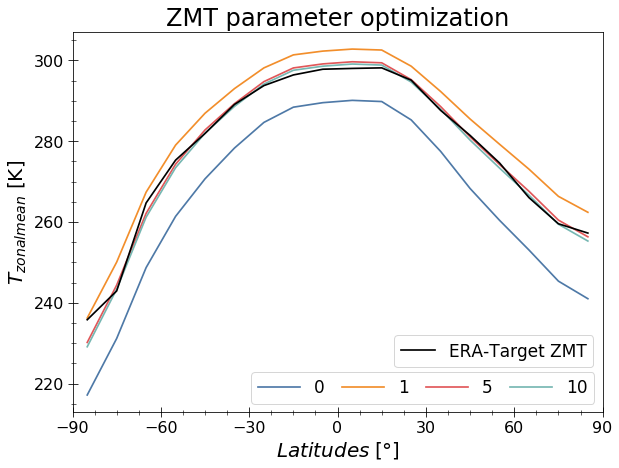

In [56]:
plt.figure(figsize=(9.5,7))
colors=['#4e79a7','#f28e2b','#e15759','#76b7b2']
j=0
for i in [0,1,5,10]:
    plt.plot(Vars.Lat,data[i][0],label=i,c=colors[j],linewidth=1.7)
    j+=1
plt.legend(fontsize=17,ncol=4,columnspacing=1,handlelength=2.5,loc='lower right')
#plt.plot(Vars.Lat,data[7][0])
line2=plt.plot(Lat_10,ZMT_10,c='k',linewidth=1.7,label='ERA-Target ZMT')
plt.xticks(np.linspace(-90,90,7)), plt.xlim(-90,90)

plt.xlabel('$Latitudes\;[°]$'),plt.ylabel('$T_{zonal mean}$ [K]')
plt.figlegend((line2),['ERA-Target ZMT'],fontsize=17,bbox_to_anchor=(0.88,0.28))
plt.title('ZMT parameter optimization')
#plt.xlim(1808,1858)
plt.savefig('Data/ZMT_Optimization_Sellers.eps',format='EPS',bbox_inches='tight')

In [62]:
print(data[-1][1])

[233.09009959 246.36990456 263.11344375 274.51305497 282.41968221
 288.55264889 293.70951581 296.98019182 297.95165858 298.47074786
 298.21671032 294.12617231 287.73587446 280.69268811 274.31756221
 268.17909919 261.60364255 257.76262812]


ValueError: x and y must have same first dimension, but have shapes (1,) and (100, 11, 18)

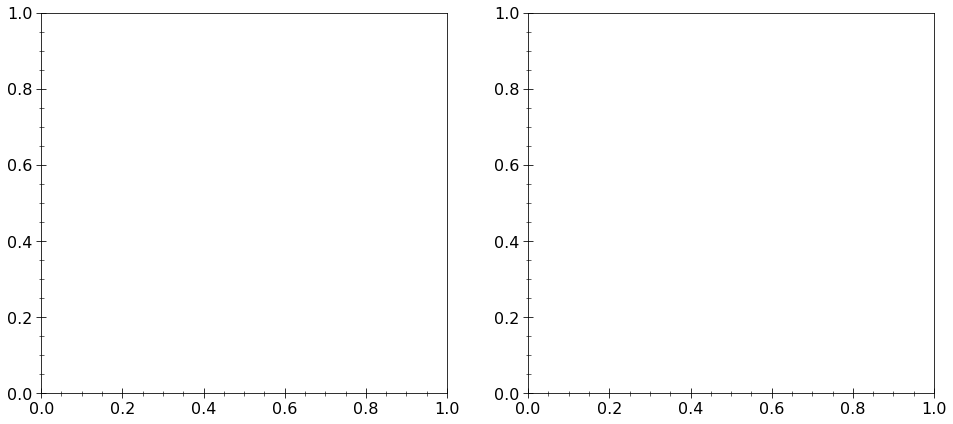

In [9]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')
Lat_ERA,ZMT_ERA=np.loadtxt('Data/ERA_ZMT_Mean.txt')
#plt.plot(Vars.Lat,data[1][-1]+elevation)
#plt.plot(Lat_10,ZMT_10)
for i in [0,1,10,99]:
    ax[0].plot(np.arange,data-data,label='Optimized_GMT')
    ax[0].legend(loc='lower right')

ax[1].plot(Vars.Lat,data[1][0]+elevation,label='ZMT Optimized_GMT')
ax[1].plot(Lat_10,ZMT_10,label='Expected ZMT')
ax[1].legend(loc='lower right')
#plt.savefig('GMT_Optimization_Comparison.eps',format='EPS',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


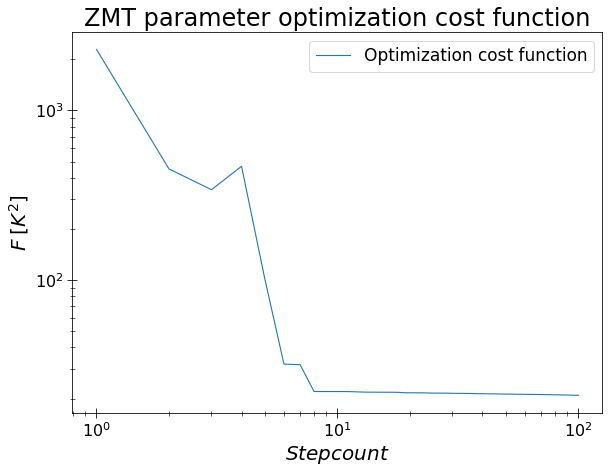

In [50]:
plt.figure(figsize=(9.5,7))
plt.plot(np.arange(100)+1,F[:,0],label='Optimization cost function')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$Stepcount$'),plt.ylabel('$F\; [K^2]$')
#plt.figlegend((line2),['ERA-Target ZMT'],fontsize=17,bbox_to_anchor=(0.858,0.215))
plt.legend(fontsize=17)
plt.title('ZMT parameter optimization cost function')
#plt.xlim(1808,1858)
plt.savefig('Data/ZMT_Optimization_F_log.eps',format='EPS',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


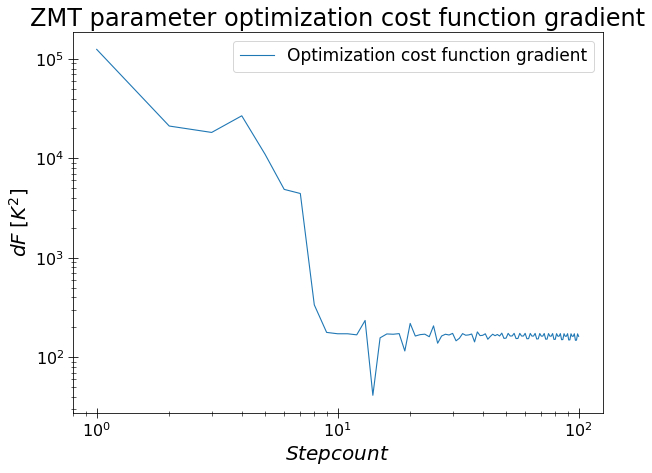

In [49]:
plt.figure(figsize=(9.5,7))
plt.plot(np.arange(100)+1,np.abs(dF[:,0]),label='Optimization cost function gradient')
plt.yscale('log')
plt.xscale('log')
#plt.ylim(-1.5e5,1e5)
plt.xlabel('$Stepcount$'),plt.ylabel('$dF\; [K^2]$')
#plt.figlegend((line2),['ERA-Target ZMT'],fontsize=17,bbox_to_anchor=(0.858,0.215))
plt.legend(fontsize=17)
plt.title('ZMT parameter optimization cost function gradient')
#plt.xlim(1808,1858)
plt.savefig('Data/ZMT_Optimization_dF_log.eps',format='EPS',bbox_inches='tight')

In [14]:
#setup={'number_of_parameters': len(P0), 'number_of_cycles': 1, 'number_of_parallels': len(P0)*2+1}
config_base=importer('Dev_Data/Optimization/Sellers.ini')
variable_importer(config_base,control=True,accuracy=1e-4)
#print(config_base)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
elevation=-0.0065*np.array(ParasCTRL[1][1])
#P_config=reshape_parameters(P0,P_pert)
labels=[['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P_optimal=[0.4668,2.4762e-15,1.1689,1.16658,1.1942]
config=add_parameters(config_base,P_optimal,labels)
#print(config)
data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)

Loading Configuration from: Dev_Data/Optimization/Sellers.ini
Starting controlrun with a temperature accuracy of 0.0001 K on the GMT over 1000 datapoints.
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Steady State reached after 29943 steps, within 41.05894374847412 seconds
Finished controlrun over 1982.035616438356 years. Runtime: 41.0869026184082 s


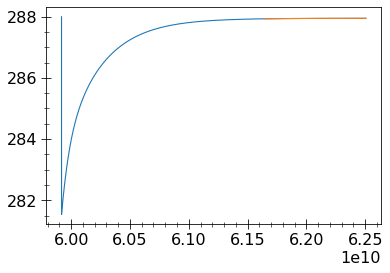

In [9]:
plt.plot(data[0],data[2])
plt.plot(data[0][-10000:],data[2][-10000:])

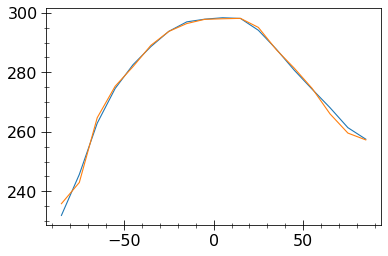

In [15]:
plt.plot(Vars.Lat,data[1][-1]+elevation)
plt.plot(Lat_10,ZMT_10)